In [40]:
from __future__ import print_function, division 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
torch.set_default_tensor_type(torch.cuda.FloatTensor)
import numpy as np

import pandas as pd 
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms, utils
import os
import datetime 
import numpy as np 
import math

##文件数据行为: x   y   z  time     ；表示一个坐标点的三个坐标分量和 采集时间 ，使用空格符分隔

def pre(source, distance, diantance1):
    f = open(source, "r")  # 源文件
    fwrit = open(distance, "a")  # 卡2068
    for s in f.readlines():
        if len(s) == 1:
            fwrit.write(s)
        else:
            s = s[:-1]
            tem = s.split()
            re = tem[1].split(':')[1] + "\t" + tem[2].split(':')[1] + "\t" + tem[3].split(':')[1] + "\t" + tem[-2] + "\t" + tem[-1] + "\n"
            # if tem[0] != "2068":
            #     fwrit1.write(re)
            # else:
            if tem[0] == "2068":
                fwrit.write(re)
    f.close()
    fwrit.close()


def file_name(file_dir, target, target1):
    path = [file_dir + '\\' + x for x in os.listdir(file_dir)]
    for p in path:
        if not os.path.isdir(p):
            pre(p, target, target1)

def split_data(splot):
    """
    按照plot划分时间段
    """
    state = "D:\\fig\\data\\pre2068Static.txt"
    unrealize = "D:\\fig\\data\\pre2068Unrealize.txt"
    Sactive = "D:\\fig\\data\\pre2068Little.txt"
    Mactive = "D:\\fig\\data\\pre2068LargeMove.txt"
    files = [state, unrealize, Sactive, Mactive]
    mask = [0., 1., 2., 3.]
    splotre = []
    lable = [] 
    for index, file in enumerate(files):
        f = open(file, "r")
        mk = mask[index]

        flag = False 
        start = ''
        obj = [] 
        for s in f.readlines():
            if len(s) <= 1:
                continue
            else:
                
                s = s[:-1]
                seq = s.split("\t")
                if flag == False :
                    #本数据序列第一点的采集时间
                    start = 0
                    now = 0
                    flag = True 
                # 当前点的采集时间
                now = now + 1
                subt = now - start 
                obj.append(np.asarray(seq[:3],dtype='float64'))
            if subt > splot:
                splotre.append(np.asarray(obj))
                lable.append(mk)
                obj.clear() 
                flag = False
    splotre = np.asarray(splotre)
    lable = np.asarray(lable)
    return splotre, lable


In [41]:
# 大幅度运动 原始数据源
p = "E:\\datacollect\\trian\\active"
# 数据预处理结果保存路径
t = "D:\\fig\\data\\pre2068LargeMove.txt"  # 卡2068对应的数据，处理结果
t1 = "D:\\fig\\data\\preLargeMove.txt"  # 其他卡的处理结果

file_name(p, t, t1)
p = "E:\\datacollect\\trian\\little"  # 原始数据源

# 数据预处理结果保存路径
t = "D:\\fig\\data\\pre2068Little.txt"  # 卡2068对应的数据，处理结果
t1 = "D:\\fig\\data\\preLittle.txt"  # 其他卡的处理结果

file_name(p, t, t1)
p = "E:\\datacollect\\trian\\static"  # 原始数据源

# 数据预处理结果保存路径
t = "D:\\fig\\data\\pre2068Static.txt"  # 卡2068对应的数据，处理结果
t1 = "D:\\fig\\data\\preStatic.txt"  # 其他卡的处理结果
file_name(p, t, t1)
# 无意识运动，如转身，手摆动
p = "E:\\datacollect\\trian\\unrealize"  # 原始数据源
# 数据预处理结果保存路径
t = "D:\\fig\\data\\pre2068Unrealize.txt"  # 卡2068对应的数据，处理结果
t1 = "D:\\fig\\data\\preUnrealize.txt"  # 其他卡的处理结果径
file_name(p, t, t1)

In [43]:
splotre, lable = split_data(69)

In [44]:
splotre.shape

(8178, 70, 3)

In [45]:
lable

array([0., 0., 0., ..., 3., 3., 3.])

In [46]:
NUM_TRAIN = 6000
index = list(range(splotre.shape[0]))
np.random.shuffle(index)
splotre = splotre[index]
lable = lable[index]
train_splot = splotre[:NUM_TRAIN-1000]
train_lable = lable[:NUM_TRAIN-1000]
val_splot = splotre[NUM_TRAIN-1000:NUM_TRAIN]
val_lable = lable[NUM_TRAIN-1000:NUM_TRAIN]
test_splot = splotre[NUM_TRAIN:]
test_lable = lable[NUM_TRAIN:]


In [47]:
class ToTensor(object):
    def __call__(self, splot):
        return torch.from_numpy(splot)
    
trans = T.Compose([
    ToTensor()
])

class LocationDataset(Dataset):
    def __init__(self, splotre, lable, transform = trans):
        self.splotre = np.transpose(splotre, (0, 2, 1))
        self.lable = lable 
        self.transform = transform 
    
    def __len__(self):
        return len(self.splotre)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        splot = self.splotre[idx] 
        lable = self.lable[idx]
        tensor = trans(splot)
        return tensor, lable
train_dataset = LocationDataset(train_splot, train_lable)
loader_train = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataset = LocationDataset(val_splot, val_lable)
loader_val = DataLoader(val_dataset, batch_size=4, shuffle=True)


In [48]:
loader_val.dataset[2]

(tensor([[2.3008, 2.2992, 2.2694, 2.2728, 2.2719, 2.2328, 2.2167, 2.2038, 2.1749,
          2.1634, 2.1713, 2.1727, 2.1810, 2.2101, 2.2295, 2.2496, 2.2843, 2.2843,
          2.2843, 2.2843, 2.2843, 2.2843, 2.2843, 2.2843, 2.2843, 2.2843, 2.2843,
          2.2843, 2.2843, 2.2843, 2.2843, 2.2843, 2.2843, 2.2843, 2.3167, 2.2927,
          2.2644, 2.2433, 2.2366, 2.2292, 2.2379, 2.2412, 2.2217, 2.2320, 2.2482,
          2.2302, 2.1856, 2.1502, 2.1444, 2.1450, 2.1621, 2.1799, 2.2003, 2.2244,
          2.2207, 2.2136, 2.2136, 2.2071, 2.1995, 2.2203, 2.2203, 2.2203, 2.2203,
          2.2203, 2.2203, 2.2832, 2.2886, 2.2653, 2.2961, 2.3382],
         [0.2886, 0.3879, 0.4675, 0.5080, 0.5594, 0.6435, 0.6447, 0.6402, 0.6848,
          0.7280, 0.7272, 0.7231, 0.7200, 0.7024, 0.7012, 0.6531, 0.5823, 0.5823,
          0.5823, 0.5823, 0.5823, 0.5823, 0.5823, 0.5823, 0.5823, 0.5823, 0.5823,
          0.5823, 0.5823, 0.5823, 0.5823, 0.5823, 0.5823, 0.5823, 0.2421, 0.2249,
          0.2482, 0.2833, 0.334

In [49]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [50]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [51]:
USE_GPU = False

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [52]:
import torch.nn.functional as F  # useful stateless functions
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

In [53]:
def check_accuracy_part34(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [56]:
channel_1 = 32 
channel_2 = 16
learning_rate = 1e-3
model = None 
optimizer = None 

model = nn.Sequential(
    nn.Conv1d(3, 64, 3, stride = 1, padding = 2),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size = 2),
    nn.Conv1d(64, 128, 2, stride = 2, padding = 2),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size = 2),
    nn.Conv1d(128, 256, 2, stride = 3, padding = 3),
    nn.ReLU(),
    Flatten(),
    nn.Linear(1280, 4)
)
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9, nesterov = True)
train_part34(model, optimizer, 8)

Iteration 0, loss = 1.2941
Got 302 / 1000 correct (30.20)

Iteration 100, loss = 1.2513
Got 653 / 1000 correct (65.30)

Iteration 200, loss = 0.7009
Got 722 / 1000 correct (72.20)

Iteration 300, loss = 0.4309
Got 842 / 1000 correct (84.20)

Iteration 400, loss = 0.4309
Got 878 / 1000 correct (87.80)

Iteration 500, loss = 0.4566
Got 914 / 1000 correct (91.40)

Iteration 600, loss = 0.6923
Got 909 / 1000 correct (90.90)

Iteration 700, loss = 0.5283
Got 929 / 1000 correct (92.90)

Iteration 800, loss = 0.0272
Got 921 / 1000 correct (92.10)

Iteration 900, loss = 0.2039
Got 951 / 1000 correct (95.10)

Iteration 1000, loss = 0.0149
Got 928 / 1000 correct (92.80)

Iteration 1100, loss = 0.0595
Got 808 / 1000 correct (80.80)

Iteration 1200, loss = 0.1522
Got 915 / 1000 correct (91.50)

Iteration 0, loss = 0.0254
Got 935 / 1000 correct (93.50)

Iteration 100, loss = 0.1032
Got 901 / 1000 correct (90.10)

Iteration 200, loss = 0.1907
Got 948 / 1000 correct (94.80)

Iteration 300, loss = 0.2

In [57]:
test_dataset = LocationDataset(test_splot, test_lable)
loader_test = DataLoader(test_dataset)

In [58]:
def test(loader,model):
    num_correct = 0 
    num_samples = 0 
    res = []
    for x, y in loader:
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        scores = model(x)
        _, preds = scores.max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        res.append(preds.item())
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return res


res = test(loader_test,model)

from sklearn import metrics

def gradeOfClassifier():
    P = metrics.precision_score(test_lable, res, average='macro')
    R = metrics.recall_score(test_lable, res, average='macro')
    # F1分数
    F1 = metrics.f1_score(test_lable, res, average='weighted')
    # 混淆矩阵
    M = metrics.confusion_matrix(test_lable, res, labels=[0.0, 1.0, 2.0, 3.0])
    print("查准率" + str(P))
    print("召回率" + str(R))
    print("F1分数" + str(F1))
    print("混淆矩阵")
    print(M)
    print()
    return P
gradeOfClassifier()

Got 2161 / 2178 correct (99.22)
查准率0.9917241145100126
召回率0.9916560141856986
F1分数0.9921813894406777
混淆矩阵
[[652   0   0   0]
 [  0 463   1   0]
 [  2   5 467   3]
 [  1   0   5 579]]



0.9917241145100126

In [61]:
import math
from lys.filter.examples.sine_wave import kalmanfilter
from lys.filter.movinAverage import MoveAverage
from lys.filter.sampleFilter import last_polyfit

# 误差绝对值 的平均值
def getMae(mearsure, value):
    sum = 0.0

    for i in range(len(value)):
        sum += abs(float(mearsure[i]) - float(value[i]))

    n = len(value)
    sum = sum / n
    print("平均绝对值误差：" + str(sum))
    print()


# 平均相对误差
def Mape(mearsure, value):
    sum = 0.0
    for i in range(1,len(value)):
        sum += abs((float(mearsure[i]) - float(value[i])) / float(value[i]))
    n = len(value)-1
    sum = sum / n
    print("平均相对误差：" + str(sum))
    print()


def Rmse(mearsure, value):
    sum = 0.0
    for i in range(len(value)):
        sum += math.pow(float(mearsure[i]) - float(value[i]), 2)
    n = len(value)
    sum = math.sqrt(sum / n)
    print("均方根差：" + str(sum))
    print()

def classifer(model, splot, path):
    resultSeqStatic = []  # 静止状态
    resultSeqUnrealized = []  # 无意识运动状态
    resultSeqBackMove = []  # 短距离往返运动
    resultSeqforward = []  # 长距离往返运动
    splotre = []
    # 运动状态分析，与剔除
    with open(path, 'r') as f:
        obj = []
        flag = False  # 是否第一次记录起始时间
        start = ''  # 当前子序列的起始时间
        for s in f.readlines():  # 按行读取数据
            if len(s) <= 1:
                continue
            else:
                
                s = s[:-1]
                seq = s.split(" ")
                if flag == False :
                    #本数据序列第一点的采集时间
                    start = 0
                    now = 0
                    flag = True 
                # 当前点的采集时间
                now = now + 1
                subt = now - start 
                myseq = [seq[1][7:], seq[2][7:], seq[3][7:]]
                obj.append(np.asarray(myseq,dtype='float64'))
            if subt > splot:
                splotre.append(np.asarray(obj))
                obj.clear() 
                flag = False
    splotre = np.asarray(splotre)
    for plot in splotre:
        tensor = torch.FloatTensor(plot.T)
        tensor = tensor.view((1,3,70))
        scores = model(tensor)
        _, state = scores.max(1)
        if state.item() == 0:
            resultSeqStatic += plot.tolist()
        elif state.item() == 1:
            resultSeqUnrealized += plot.tolist()
        elif state.item() == 2:
            resultSeqBackMove += plot.tolist()
        elif state.item() == 3:
            resultSeqforward += plot.tolist()
    return resultSeqStatic, resultSeqUnrealized, resultSeqBackMove, resultSeqforward

In [60]:
def countdistance(seq):
    distance = 0.0
    # 计算一个序列的运动距离
    if len(seq) <= 1:  # 只有一个点时，距离为零
        return distance
    else:
        p1 = seq[0]  # 轨迹的第一个点
        for value in seq[1:]:
            p2 = value
            d = np.sqrt((float(p1[0]) - float(p2[0])) ** 2 + (float(p1[1]) - float(p2[1])) ** 2)  # 两点间的距离
            if d < 2.0:
                distance += d
            p1 = p2
        distance = float("%.2f" % distance)
        return distance


# 卡尔曼滤波器
def kalmanFilter(seq):
    x_value = []
    y_value = []
    for i in range(len(seq)):
        temp = seq[i]
        x_value.append(float(temp[0]))
        y_value.append(float(temp[1]))
    x_value = kalmanfilter(x_value, len(x_value))  # 滤波

    length = min(len(x_value), len(y_value))  # 数组长度
    sequence = [[x_value[i], y_value[i]] for i in range(0, length)]
    return sequence


# 最小二乘法拟合多项式
def leastfit(seq):
    result = last_polyfit(seq)
    return result


def MovingAverage(seq):
    obj = MoveAverage(seq, 11)  # 创建对象
    result = obj.smooth()  # 平滑数据

    return result


In [62]:
dirPath = "D:\\fig\\test\\data"
path = [dirPath + '\\' + x for x in os.listdir(dirPath)]
resultSeqStatic, resultSeqUnrealized, resultSeqBackMove, resultSeqforward = classifer(model, 69, path[0])
print(countdistance(resultSeqStatic))
print(countdistance(resultSeqUnrealized))
print(countdistance(resultSeqBackMove))
print(countdistance(resultSeqforward))
countdistance(resultSeqBackMove) + countdistance(resultSeqUnrealized) + countdistance(resultSeqforward)

0.14
0.0
3.56
0.0


3.56

In [63]:
# 误差曲线图
def main(slot, other=15):
    dirPath = "E:\\datacollect\\test\\data"
    path = [dirPath + '\\' + x for x in os.listdir(dirPath)]

    # 分类其模型
    # classfilter = getKnnClassifer(slot, other)

    classfilter = getSvmClassifer(slot)

    #
    # classfilter = getMplClassifer(slot)
    result = []
    result1 = []
    result2 = []
    for p in path:
        distance = 0.0  # 去除静止状态
        distance1 = 0.0  # 除去静止状态和无意识状态后的轨迹的距离
        distance2 = 0.0  # 除去静止状态后，在拟合处理数据的轨迹的距离
        # 各状态下的轨迹
        resultSeqStatic, resultSeqUnrealized, resultSeqBackMove, resultSeqforward = classifer(classfilter, slot, p)

        # 除去静止状态后的轨迹的距离
        distance = countdistance(resultSeqUnrealized) + countdistance(resultSeqBackMove) + countdistance(
            resultSeqforward)

        result.append(distance)

        # 除去静止状态和无意识状态后的轨迹的距离
        distance1 = countdistance(resultSeqBackMove) + countdistance(resultSeqforward)
        result1.append(distance1)

        # #除去静止状态后，在拟合处理数据的轨迹的距离
        distance2 = countdistance(MovingAverage(resultSeqUnrealized)) + countdistance(
            MovingAverage(resultSeqBackMove)) + countdistance(
            MovingAverage(resultSeqforward))
        result2.append(distance2)

    return result, result1, result2

In [64]:
# index=1  卡尔曼滤波
# index=2  最小二乘
# index=3  滑动均值
def deal(index, seq):
    if index == 1:
        return kalmanFilter(seq)
    elif index == 2:
        return leastfit(seq)
    elif index == 3:
        return MovingAverage(seq)


In [65]:
# value:真实值
# 使用三种方法分别处理除静止之外的数据
def main1(value, slot):
    dirPath = "D:\\项目\\廖煜胜-论文\\论文\\数据与程序\\datacollect\\test\\data"
    path = [dirPath + '\\' + x for x in os.listdir(dirPath)]

    # 分类其模型
    # classfilter = getKnnClassifer(slot, other)

    # classfilter = getSvmClassifer(slot)

    #
    #classfilter = getMplClassifer(slot)
    classfilter = model

    print("无意识运动状态  " + "往返  " + "前行")
    m = 0
    for i in [1, 2, 3]:
        for j in [1, 2, 3]:
            for k in [1, 2, 3]:
                distance2 = 0.0  #
                for p in path:
                    # 各状态下的轨迹
                    resultSeqStatic, resultSeqUnrealized, resultSeqBackMove, resultSeqforward = classifer(classfilter,
                                                                                                          slot, p)
                    # #除去静止状态后，在拟合处理数据的轨迹的距离
                    d1 = countdistance(deal(i, resultSeqUnrealized))
                    d2 = countdistance(deal(j, resultSeqBackMove))
                    d3 = countdistance(deal(k, resultSeqforward))
                    distance2 = distance2 + d1 + d2 + d3
                if value[m] == 0.:
                    continue
                print(str(i) + " " + str(j) + " " + str(k) + " ", end=" ")
                err = (distance2 - value[m]) / len(path)
                print("误差" + str(err), end=" ")

                e = (distance2 - value[m]) / value[m]
                print("相对误差率" + str(e))
                print()
                m += 1

    return


# 对不同状态的数据处理
def fn(i, j, k, classfilter, slot, path):
    re = []
    for p in path:
        # 各状态下的轨迹
        resultSeqStatic, resultSeqUnrealized, resultSeqBackMove, resultSeqforward = classifer(classfilter,
                                                                                              slot, p)
        # #除去静止状态后，在拟合处理数据的轨迹的距离
        d1 = countdistance(deal(i, resultSeqUnrealized))
        d2 = countdistance(deal(j, resultSeqBackMove))
        d3 = countdistance(deal(k, resultSeqforward))
        distance2 = d1 + d2 + d3
        re.append(distance2)
    return re


def draw2(title, measure, trueValue):
    plt.figure(title)
    x = [i for i in range(1, 13)]
    plt.xlabel('轨迹序号', fontproperties='SimHei', fontsize=10)
    plt.ylabel('轨迹长度(米)', fontproperties='SimHei', fontsize=10)
    plt.title(title)

    plt.plot(x, measure, marker='+', linestyle='--', label='1d-CNN')  # 计算值

    plt.plot(x, trueValue, marker='o', linestyle='-', label='真实距离')  # 真值
    plt.legend(loc='lower right')  # label生效
    plt.xticks(x)
    plt.show()

In [78]:
def main2(slot):
    dirPath = "D:\\项目\\廖煜胜-论文\\论文\\数据与程序\\datacollect\\test\\data"
    path = [dirPath + '\\' + x for x in os.listdir(dirPath)]
    i = 2
    j = 2
    k = 1
    re = fn(i, j, k, model, slot, path)

    return re

In [67]:
def getvalue(path):
    f = open(path, "r")  # 源文件
    result = []
    for s in f.readlines():
        num = float(s.split("  ")[1][:-1])
        result.append(num)
    return result


# 求和
def distanceofseq(value):
    val_sum = 0
    for i in range(len(value)):
        val_sum += float(value[i])
    return val_sum


def SD(measure, value):
    d = 0  # 标准差
    err = 0  # 平均误差
    sum_value = 0
    sum_measure = 0
    for i in range(len(value)):
        d = d + (value[i] - measure[i]) ** 2
        err += measure[i] - value[i]
        sum_value += value[i]
        sum_measure += measure[i]

    d = np.sqrt(d) / len(value)
    err = err / len(value)
    ff = (sum_measure - sum_value) / sum_value

    print("误差： " + str(err))
    print("相对误差率： " + str(ff))
    print("标准差： " + str(d))
    print()


In [79]:
path = "D:\\项目\\廖煜胜-论文\\论文\\数据与程序\\datacollect\\test\\truevalue.txt"
value = getvalue(path)  # 真值
measure = main2(69)
getMae(measure, value)
Mape(measure, value)
Rmse(measure, value)

平均绝对值误差：204.1291666666667

平均相对误差：0.18419645380462735

均方根差：240.6796985449057



In [76]:
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
def draw4(title, measure, trueValue, label):
    plt.figure(title)
    x = [i for i in range(1, 13)]
    plt.xlabel('轨迹序号', fontproperties='SimHei', fontsize=10)
    plt.ylabel('轨迹长度（米）', fontproperties='SimHei', fontsize=10)
    plt.title("计算值与真实值对比")

    plt.subplots_adjust(bottom=0.15)  # 图边距t
    plt.subplots_adjust(left=0.15)
    plt.xticks(x)
    for i in range(1, len(x)):
        d = ((measure[i] - trueValue[i]) / trueValue[i]) * 100
        text = float("%.2f" % d)
        plt.text(x[i] - 0.4, measure[i] + 30, str(text) + "%", fontdict={'size': '10'})

    plt.plot(x, measure, marker='*', linestyle='-.', label=label)  # 计算值
    plt.plot(x, trueValue, marker='o', linestyle='-', label='真实值')  # 真值
    plt.legend(loc='lower right')  # label生效
    plt.savefig("D:\\fig\\picture\\" + str(title) + ".png")

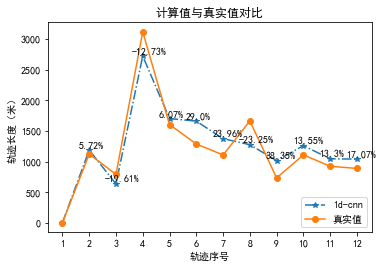

In [80]:
draw4("1d-cnn", measure, value, "1d-cnn")

In [4]:
# 基于运动状态的距离统计
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
from lys.classifier.mlpclassifier import getMplClassifer
from lys.classifier.mysvm1 import getSvmClassifer
from lys.classifier.sklearnknn import getKnnClassifer
from lys.dataprocess1.extractcharact import getExtract

# 判定轨迹的各子序列的状态
# 参数1：分类器对象
# 参数2：时间间隔
# 参数3：轨迹数据路径
from lys.drawimg.resultOfClassifier import draw3, draw1, draw4

# 采用分类器判定轨迹子序列状态
from lys.evaluate import getMae, Mape, Rmse
from filter.examples.sine_wave import kalmanfilter
from filter.movinAverage import MoveAverage
from filter.sampleFilter import last_polyfit


def classifer(classifilter, slot, path):
    resultSeqStatic = []  # 静止状态
    resultSeqUnrealized = []  # 无意识运动状态
    resultSeqBackMove = []  # 短距离往返运动
    resultSeqforward = []  # 长距离往返运动

    # 运动状态分析，与剔除
    with open(path, 'r') as f:
        timeSequen = f.readlines()  # 读取整个文件数据
        slopSequen = []  # 保存当前正在处理的子序列
        flag = False  # 是否第一次记录起始时间
        start = ''  # 当前子序列的起始时间
        for s in timeSequen:  # 按行读取数据
            if len(s) <= 1:  # 跳过空行
                continue
            else:
                s = s[:-1]  # 去掉换行符
                seq = s.split(" ")  # 按"\t"切分字符
                if flag == False:
                    start = seq[4] + " " + seq[5]  # 本子数据序列第一个点采集时间
                    flag = True
                now = seq[4] + " " + seq[5]  # 当前点采集时间
                subt = (datetime.datetime.strptime(now, "%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(start,
                                                                                                          "%Y-%m-%d %H:%M:%S")).seconds
                # 逐个获取序列
                if subt > slot:
                    # 子序列状态判定
                    if len(slopSequen) > 0:
                        vector = getExtract(slopSequen)  # 计算序列特征[[v1,v2,v3]]
                        state = classifilter.predict(vector)[0]  # 判断当前序列的运动状态
                        if int(state) == 1:
                            resultSeqStatic += slopSequen
                        elif int(state) == 2:
                            resultSeqUnrealized += slopSequen
                        elif int(state) == 3:
                            resultSeqBackMove += slopSequen
                        elif int(state) == 4:
                            resultSeqforward += slopSequen

                    # 后续处理
                    slopSequen = []
                    temp = []
                    temp.append(float(seq[1].split(":")[1]))
                    temp.append(float(seq[2].split(":")[1]))
                    slopSequen.append(temp)
                    start = now
                else:
                    temp = []
                    temp.append(float(seq[1].split(":")[1]))
                    temp.append(float(seq[2].split(":")[1]))
                    slopSequen.append(temp)

    # 最后一个子序列的状态（其长度可能比slot小）
    # if len(slopSequen) > 0:
    #     vector = getExtract(slopSequen)  # 计算序列特征[[v1,v2,v3]]
    #     state = classifilter.predict(vector)[0]  # 判断当前序列的运动状态
    #     if int(state) == 1:
    #         resultSeqStatic += slopSequen
    #     elif int(state) == 2:
    #         resultSeqUnrealized += slopSequen
    #     elif int(state) == 3:
    #         resultSeqBackMove += slopSequen
    #     elif int(state) == 4:
    #         resultSeqforward += slopSequen
    return resultSeqStatic, resultSeqUnrealized, resultSeqBackMove, resultSeqforward


# 计算一个序列对应的距离
# 参数：序列
def countdistance(seq):
    distance = 0.0
    # 计算一个序列的运动距离
    if len(seq) <= 1:  # 只有一个点时，距离为零
        return distance
    else:
        p1 = seq[0]  # 轨迹的第一个点
        for value in seq[1:]:
            p2 = value
            d = np.sqrt((float(p1[0]) - float(p2[0])) ** 2 + (float(p1[1]) - float(p2[1])) ** 2)  # 两点间的距离
            if d < 2.0:
                distance += d
            p1 = p2
        distance = float("%.2f" % distance)
        return distance


# 卡尔曼滤波器
def kalmanFilter(seq):
    x_value = []
    y_value = []
    for i in range(len(seq)):
        temp = seq[i]
        x_value.append(float(temp[0]))
        y_value.append(float(temp[1]))
    x_value = kalmanfilter(x_value, len(x_value))  # 滤波

    length = min(len(x_value), len(y_value))  # 数组长度
    sequence = [[x_value[i], y_value[i]] for i in range(0, length)]
    return sequence


# 最小二乘法拟合多项式
def leastfit(seq):
    result = last_polyfit(seq)
    return result


def MovingAverage(seq):
    obj = MoveAverage(seq, 11)  # 创建对象
    result = obj.smooth()  # 平滑数据

    return result


# 误差曲线图
def main(slot, other=15):
    dirPath = "D:\\项目\\廖煜胜-论文\\论文\\数据与程序\\datacollect\\test\\data"
    path = [dirPath + '\\' + x for x in os.listdir(dirPath)]

    # 分类其模型
    # classfilter = getKnnClassifer(slot, other)

    classfilter = getSvmClassifer(slot)

    #
    # classfilter = getMplClassifer(slot)
    result = []
    result1 = []
    result2 = []
    for p in path:
        distance = 0.0  # 去除静止状态
        distance1 = 0.0  # 除去静止状态和无意识状态后的轨迹的距离
        distance2 = 0.0  # 除去静止状态后，在拟合处理数据的轨迹的距离
        # 各状态下的轨迹
        resultSeqStatic, resultSeqUnrealized, resultSeqBackMove, resultSeqforward = classifer(classfilter, slot, p)

        # 除去静止状态后的轨迹的距离
        distance = countdistance(resultSeqUnrealized) + countdistance(resultSeqBackMove) + countdistance(
            resultSeqforward)

        result.append(distance)

        # 除去静止状态和无意识状态后的轨迹的距离
        distance1 = countdistance(resultSeqBackMove) + countdistance(resultSeqforward)
        result1.append(distance1)

        # #除去静止状态后，在拟合处理数据的轨迹的距离
        distance2 = countdistance(MovingAverage(resultSeqUnrealized)) + countdistance(
            MovingAverage(resultSeqBackMove)) + countdistance(
            MovingAverage(resultSeqforward))
        result2.append(distance2)

    return result, result1, result2


# index=1  卡尔曼滤波
# index=2  最小二乘
# index=1  滑动均值
def deal(index, seq):
    if index == 1:
        return kalmanFilter(seq)
    elif index == 2:
        return leastfit(seq)
    elif index == 3:
        return MovingAverage(seq)


# value:真实值
# 使用三种方法分别处理除静止之外的数据
def main1(value, slot, other=15):
    dirPath = "D:\\项目\\廖煜胜-论文\\论文\\数据与程序\\datacollect\\test\\data"
    path = [dirPath + '\\' + x for x in os.listdir(dirPath)]

    # 分类其模型
    # classfilter = getKnnClassifer(slot, other)

    # classfilter = getSvmClassifer(slot)

    #
    classfilter = getMplClassifer(slot)

    print("无意识运动状态  " + "往返  " + "前行")
    for i in [1, 2, 3]:
        for j in [1, 2, 3]:
            for k in [1, 2, 3]:
                distance2 = 0.0  #
                for p in path:
                    # 各状态下的轨迹
                    resultSeqStatic, resultSeqUnrealized, resultSeqBackMove, resultSeqforward = classifer(classfilter,
                                                                                                          slot, p)
                    # #除去静止状态后，在拟合处理数据的轨迹的距离
                    d1 = countdistance(deal(i, resultSeqUnrealized))
                    d2 = countdistance(deal(j, resultSeqBackMove))
                    d3 = countdistance(deal(k, resultSeqforward))
                    distance2 = distance2 + d1 + d2 + d3

                print(str(i) + " " + str(j) + " " + str(k) + " ", end=" ")
                err = (distance2 - value) / len(path)
                print("误差" + str(err), end=" ")

                e = (distance2 - value) / value
                print("相对误差率" + str(e))
                print()

    return


# 对不同状态的数据处理
def fn(i, j, k, classfilter, slot, path):
    re = []
    for p in path:
        # 各状态下的轨迹
        resultSeqStatic, resultSeqUnrealized, resultSeqBackMove, resultSeqforward = classifer(classfilter,
                                                                                              slot, p)
        # #除去静止状态后，在拟合处理数据的轨迹的距离
        d1 = countdistance(deal(i, resultSeqUnrealized))
        d2 = countdistance(deal(j, resultSeqBackMove))
        d3 = countdistance(deal(k, resultSeqforward))
        distance2 = d1 + d2 + d3
        re.append(distance2)
    return re


def draw2(title, knn_measure, svm_measure, mlp_measure, trueValue):
    plt.figure(title)
    x = [i for i in range(1, 13)]
    plt.xlabel('轨迹序号', fontproperties='SimHei', fontsize=10)
    plt.ylabel('轨迹长度(米)', fontproperties='SimHei', fontsize=10)
    plt.title(title)

    plt.subplots_adjust(bottom=0.15)  # 图边距t
    plt.subplots_adjust(left=0.15)

    plt.plot(x, knn_measure, marker='+', linestyle='--', label='KNN')  # 计算值
    plt.plot(x, svm_measure, marker='*', linestyle='-.', label='SVM')  # 计算值
    plt.plot(x, mlp_measure, marker='p', linestyle=':', label='MLP')  # 计算值

    plt.plot(x, trueValue, marker='o', linestyle='-', label='真实距离')  # 真值
    plt.legend(loc='lower right')  # label生效
    plt.xticks(x)
    plt.show()


# value:真实值
# 使用三种方法分别处理除静止之外的数据
def main2(index, slot, other=15):
    dirPath = "D:\\项目\\廖煜胜-论文\\论文\\数据与程序\\datacollect\\test\\data"
    path = [dirPath + '\\' + x for x in os.listdir(dirPath)]

    classfilter = ""
    if index == 1:
        classfilter = getKnnClassifer(slot, other)
    elif index == 2:
        classfilter = getSvmClassifer(slot)
    elif index == 3:
        classfilter = getMplClassifer(slot)

    i = 1
    j = 2
    k = 1
    re = fn(i, j, k, classfilter, slot, path)

    return re


# 读取真值
def getvalue(path):
    f = open(path, "r")  # 源文件
    result = []
    for s in f.readlines():
        num = float(s.split("  ")[1][:-1])
        result.append(num)
    return result


# 求和
def distanceofseq(value):
    val_sum = 0
    for i in range(len(value)):
        val_sum += float(value[i])
    return val_sum


def SD(measure, value):
    d = 0  # 标准差
    err = 0  # 平均误差
    sum_value = 0
    sum_measure = 0
    for i in range(len(value)):
        d = d + (value[i] - measure[i]) ** 2
        err += measure[i] - value[i]
        sum_value += value[i]
        sum_measure += measure[i]

    d = np.sqrt(d) / len(value)
    err = err / len(value)
    ff = (sum_measure - sum_value) / sum_value

    print("误差： " + str(err))
    print("相对误差率： " + str(ff))
    print("标准差： " + str(d))
    print()


path = "D:\\项目\\廖煜胜-论文\\论文\\数据与程序\\datacollect\\test\\truevalue.txt"
value = getvalue(path)  # 真值
knn_measure = main2(1, 35, other=15)
svm_measure = main2(2, 35, other=15)
mlp_measure = main2(3, 35, other=15)


ModuleNotFoundError: No module named 'dataprocess1'